In [1]:
import pandas as pd
import numpy as np

try:
    import geocoder
except:
    !pip install geocoder
    import geocoder
    
#from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
    

In [2]:
import requests
import folium

In [4]:
# Getting Latitudes and longitudes of Pune

location = geocoder.arcgis('Pune, India')
latitude = location.latlng[0]
longitude = location.latlng[1]
print(latitude,longitude)

18.504220000000032 73.85302000000007


In [4]:
data = requests.get('https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Pune').text

soup = BeautifulSoup(data,'html.parser')

neighbourhood_list =[]

#find_all to get whole data
#for i in soup.find_all('div',class_='mw-category')[0].find_all('a'):
#for store in soup.find_all('div',class_='mw_category')[0].find_all('a'):
    #neigbourhood_list.append(store.text)
    
for i in soup.find_all('div',class_='mw-category')[0].find_all('a'):
    neighbourhood_list.append(i.text)
    
    
neighbourhood_df = pd.DataFrame(neighbourhood_list,columns=['Locality'])    
neighbourhood_df.head()
    



,Locality
0,Appa Balwant Chowk
1,"Aundh, Pune"
2,Balewadi
3,Baner
4,Bavdhan


In [7]:
neighbourhood_df.shape

(58, 1)

In [9]:
def calculate_latitude_longitude_all_areas(localities):
    locate = geocoder.arcgis('{},Pune,India'.format(localities))
    getlatlong = locate.latlng
    return getlatlong

In [11]:
# Getting Latitudes and Longitudes for All Areas of Pune

store_localities =[]

for i in neighbourhood_df['Locality'].tolist():
    store_localities.append(calculate_latitude_longitude_all_areas(i))
    

In [12]:
store_localities[:5]

[[18.516483671884753, 73.85387026191101],
 [18.563450000000046, 73.81227000000007],
 [18.576020000000028, 73.77983000000006],
 [18.548200000000065, 73.77316000000008],
 [18.517544858465925, 73.77853184068661]]

In [13]:
coordinates = pd.DataFrame(store_localities,columns=['Latitudes','Longitudes'])

neighbourhood_df['Latitudes']=coordinates['Latitudes']
neighbourhood_df['Longitudes']=coordinates['Longitudes']

neighbourhood_df.head()

,Locality,Latitudes,Longitudes
0,Appa Balwant Chowk,18.516484,73.853870
1,"Aundh, Pune",18.563450,73.812270
2,Balewadi,18.576020,73.779830
3,Baner,18.548200,73.773160
4,Bavdhan,18.517545,73.778532


In [15]:
neighbourhood_df[neighbourhood_df['Locality']=='Kothrud']

,Locality,Latitudes,Longitudes
24,Kothrud,18.50517,73.80245


In [31]:
Pune_map = folium.Map(location=[18.504220000000032,73.85302000000007],zoom_start=11)

#adding markers to the map for localities
#marker for Pune
#folium.Marker([blr_lat, blr_lng], popup='<i>Pune</i>', color='red', tooltip="Click to see").add_to(blr_map)

#markers for localities
for latitude,longitude,name in zip(neighbourhood_df['Latitudes'],neighbourhood_df['Longitudes'],neighbourhood_df['Locality']):
    folium.CircleMarker(
        [latitude, longitude],
        radius=6,
        color='blue',
        popup=name,
        fill=True,
        fill_color='#3186ff'
    ).add_to(Pune_map)

Pune_map

In [32]:
#foursquare
CLIENT_ID = 'M1NURV4RJYRINESBG1AZJ2LLFM0VN4K4FIDUHYQRK5GO0RBL'
CLIENT_SECRET = 'SRW3IY5XJ5G3M3CSYKVABCW2B3DDDR5QEELMBNJX1UX5CDVI'
VERSION = '20180605' # Foursquare API version

In [36]:
Limit = 10
radius = 2000

venues =[]

for lat,long,locality in zip(neighbourhood_df['Latitudes'],neighbourhood_df['Longitudes'],neighbourhood_df['Locality']):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, long, VERSION, radius, Limit)
    results = requests.get(url).json()['response']['groups'][0]['items']
    
    
    for venue in results:
        venues.append((locality, lat, long, venue['venue']['name'], venue['venue']['location']['lat'], venue['venue']['location']['lng'], venue['venue']['categories'][0]['name'], venue['venue']['id']))    
        
    #for venue in results:
        #venues.append((locality,lat,long,venue['venue']['name'],venue['venue']['location']['lat'],venue['venue']['categories'][0]['name']))

In [37]:
venues[0]

('Appa Balwant Chowk',
 18.516483671884753,
 73.85387026191101,
 'Sujata Mastani',
 18.511792754341577,
 73.85214493967393,
 'Ice Cream Shop',
 '4bd12ba141b9ef3b12a4fbe5')

In [38]:
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Locality', 'Latitude', 'Longitude', 'Venue name', 'Venue Lat', 'Venue Lng', 'Venue Category', 'Venue ID']
venues_df.head()

,Locality,Latitude,Longitude,Venue name,Venue Lat,Venue Lng,Venue Category,Venue ID
0,Appa Balwant Chowk,18.516484,73.85387,Sujata Mastani,18.511793,73.852145,Ice Cream Shop,4bd12ba141b9ef3b12a4fbe5
1,Appa Balwant Chowk,18.516484,73.85387,Bhagat Tarachand,18.514332,73.851317,Indian Restaurant,4c41785da5c5ef3bb73eb06f
2,Appa Balwant Chowk,18.516484,73.85387,Hotel Madhuban,18.519248,73.848688,Tea Room,50f6c177e4b0e9762504f426
3,Appa Balwant Chowk,18.516484,73.85387,Raja Dinkar Kelkar museum,18.510744,73.854389,History Museum,4d96d24fc910d7ce1b454755
4,Appa Balwant Chowk,18.516484,73.85387,Mad Over Donuts,18.519335,73.845320,Donut Shop,4feebcafe4b0da11fdbe582b


In [41]:
#Getting the list of all the categories of all the restaurant present in venues_df dataframe
complex_df = pd.DataFrame({'Venue Category': venues_df['Venue Category'],'Strength':venues_df['Venue Category']})
complex_df = complex_df.groupby(['Venue Category']).count()
complex_df = complex_df.sort_values(['Strength'],ascending=False)
print(complex_df.head())

print("We can see that most restaurants belongs to Indian Restaurant category i.e. {}".format(complex_df['Strength'][0]))

                               Strength
Venue Category                         
Indian Restaurant                    61
Ice Cream Shop                       35
Snack Place                          26
Café                                 23
Vegetarian / Vegan Restaurant        23
We can see that most restaurants belongs to Indian Restaurant category i.e. 61


In [42]:
demo1_df = pd.DataFrame({'Venue Category':complex_df.index[:50]})
category_strength=[]
for i in range(50):
    category_strength.append(complex_df['Strength'][i])
demo2_df = pd.DataFrame(category_strength, columns=['Strength'])
demo_df = pd.DataFrame({'Venue Category': demo1_df['Venue Category'], 'Strength': demo2_df['Strength']})
demo_df.head()

,Venue Category,Strength
0,Indian Restaurant,61
1,Ice Cream Shop,35
2,Snack Place,26
3,Café,23
4,Vegetarian / Vegan Restaurant,23


In [44]:
#import WordCloud
!pip install wordcloud
# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Wordcloud is installed and imported!


In [47]:
word_string=''
for i in range(50):
    tmp = demo_df['Venue Category'][i]
    if len(tmp.split(' ')) == 1:
        word_string = word_string + (tmp + ' ')*demo_df['Strength'][i]
    else:
        part = tmp.split(' ')
        tmp = part[0]+'_'+part[1]
        word_string = word_string + (tmp + ' ')*demo_df['Strength'][i]

In [51]:
import matplotlib.pyplot as plt


Word cloud created!


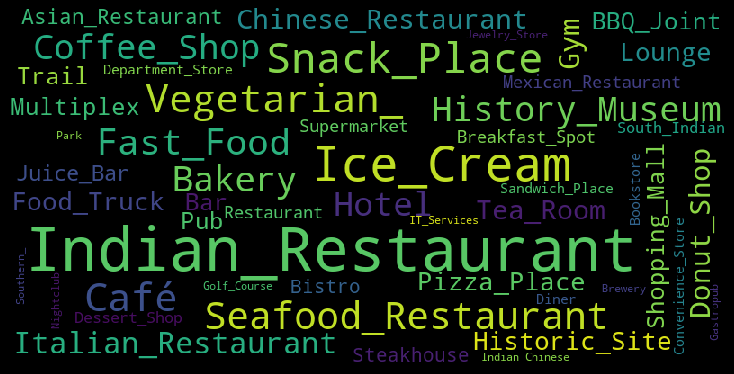

In [52]:
wordcloud = WordCloud(width=800, height=400, collocations=False).generate(word_string)
print('Word cloud created!')
# Open a plot of the generated image.

plt.figure( figsize=(10,9), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [53]:
#List of 50 most common categories of restuarants in Bangalore City
restaurant_categories = complex_df.index[0:50]
restaurant_categories

Index(['Indian Restaurant', 'Ice Cream Shop', 'Snack Place', 'Café',
       'Vegetarian / Vegan Restaurant', 'Seafood Restaurant',
       'Fast Food Restaurant', 'Bakery', 'History Museum', 'Coffee Shop',
       'Hotel', 'Italian Restaurant', 'Gym', 'Donut Shop', 'Tea Room',
       'Chinese Restaurant', 'Food Truck', 'Lounge', 'Historic Site',
       'Pizza Place', 'Bar', 'BBQ Joint', 'Trail', 'Multiplex',
       'Shopping Mall', 'Pub', 'Juice Bar', 'Asian Restaurant', 'Bistro',
       'Steakhouse', 'Mexican Restaurant', 'Supermarket', 'Breakfast Spot',
       'Restaurant', 'South Indian Restaurant', 'Dessert Shop',
       'Department Store', 'Sandwich Place', 'Diner', 'Convenience Store',
       'Bookstore', 'Jewelry Store', 'Indian Chinese Restaurant', 'Nightclub',
       'IT Services', 'Golf Course', 'Gastropub', 'Park',
       'Southern / Soul Food Restaurant', 'Brewery'],
      dtype='object', name='Venue Category')

In [54]:
venue_etables = venues_df[venues_df['Venue Category'].isin(['Indian Restaurant', 'Café', 'Ice Cream Shop', 'Fast Food Restaurant',
       'Pizza Place', 'Coffee Shop', 'Hotel', 'Chinese Restaurant', 'Lounge',
       'Italian Restaurant', 'Bakery', 'Pub', 'Restaurant',
       'Asian Restaurant', 'Breakfast Spot', 'Bar', 'Brewery', 'Burger Joint',
       'Shopping Mall', 'Sandwich Place', 'Vegetarian / Vegan Restaurant',
       'BBQ Joint', 'Snack Place', 'Park', 'Juice Bar',
       'South Indian Restaurant', 'Tea Room',
       'Middle Eastern Restaurant', 'Dessert Shop', 'Donut Shop', 'Bookstore',
       'Multiplex', 'Cocktail Bar',
       'Seafood Restaurant', 'Mexican Restaurant', 'French Restaurant',
       'Andhra Restaurant', 'Korean Restaurant', 'Cupcake Shop',
       'Karnataka Restaurant', 'Steakhouse', 'Boutique', 'Liquor Store',
       'Arcade', 'Deli / Bodega', 'Bus Station'])]

In [55]:
def addingtip(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}&radius={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, radius, LIMIT)
    stats = requests.get(url).json()['response']
    tipcount = stats['venue']['stats']['tipCount']
    return tipcount

In [60]:
demo1_df.head()


,Venue Category
0,Indian Restaurant
1,Ice Cream Shop
2,Snack Place
3,Café
4,Vegetarian / Vegan Restaurant


In [59]:
demo2_df.head()

,Strength
0,61
1,35
2,26
3,23
4,23


In [62]:
blr_onehot = pd.get_dummies(venues_df[['Venue Category']], prefix="", prefix_sep="")

blr_onehot['Locality'] = venues_df['Locality']

#moving the locality column to the front
blr_onehot = blr_onehot[ [ 'Locality' ] + [ col for col in blr_onehot.columns if col!='Locality' ] ]
blr_onehot.head(10)

,Locality,ATM,American Restaurant,Arcade,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Garden,Bistro,...,South Indian Restaurant,Southern / Soul Food Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Tea Room,Trail,Vegetarian / Vegan Restaurant,Zoo
0,Appa Balwant Chowk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Appa Balwant Chowk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Appa Balwant Chowk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,Appa Balwant Chowk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Appa Balwant Chowk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Appa Balwant Chowk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Appa Balwant Chowk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Appa Balwant Chowk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Appa Balwant Chowk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Appa Balwant Chowk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
#Grouping the categories
blr_grouped = blr_onehot.groupby(['Locality']).mean().reset_index()
print(blr_grouped.shape)
blr_grouped.head()

(56, 81)


,Locality,ATM,American Restaurant,Arcade,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Garden,Bistro,...,South Indian Restaurant,Southern / Soul Food Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Tea Room,Trail,Vegetarian / Vegan Restaurant,Zoo
0,Appa Balwant Chowk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0
1,"Aundh, Pune",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Balewadi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,...,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Baner,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bavdhan,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
len(blr_grouped[blr_grouped['Italian Restaurant'] > 0])

10

In [65]:
blr_italian = blr_grouped[['Locality', 'Italian Restaurant']]
blr_italian.head()

,Locality,Italian Restaurant
0,Appa Balwant Chowk,0.0
1,"Aundh, Pune",0.0
2,Balewadi,0.1
3,Baner,0.1
4,Bavdhan,0.0


In [70]:
blr_map = folium.Map(location=[18.504220000000032,73.85302000000007 ],zoom_start=11)



#markers for localities
for latitude,longitude,name,strength in zip(neighbourhood_df["Latitudes"], neighbourhood_df["Longitudes"], neighbourhood_df["Locality"], blr_italian["Italian Restaurant"]):
    folium.CircleMarker(
        [latitude, longitude],
        radius=strength*300,
        color='green',
        popup=name,
        fill=True,
        fill_color='#3186ff'
    ).add_to(blr_map)

blr_map

In [72]:
from sklearn.cluster import KMeans

cluster = 3 

#Dataframe for clustering
blr_clustering = blr_italian.drop(['Locality'], 1)

#run K-means clustering
k_means = KMeans(init="k-means++", n_clusters=cluster, n_init=12).fit(blr_clustering)

#getting the labels for first 10 locality 
print(k_means.labels_[0:10])

[1 1 2 2 1 1 1 1 1 1]


In [73]:
blr_labels = blr_italian.copy()

#adding label to blr_labels
blr_labels["Cluster Label"] = k_means.labels_

blr_labels.head()

,Locality,Italian Restaurant,Cluster Label
0,Appa Balwant Chowk,0.0,1
1,"Aundh, Pune",0.0,1
2,Balewadi,0.1,2
3,Baner,0.1,2
4,Bavdhan,0.0,1


In [75]:
#Merging the blr_labels and neig_df dataframes to get the latitude and longitudes for each locality
blr_labels = blr_labels.join(neighbourhood_df.set_index('Locality'), on='Locality')
blr_labels.head()

,Locality,Italian Restaurant,Cluster Label,Latitudes,Longitudes
0,Appa Balwant Chowk,0.0,1,18.516484,73.853870
1,"Aundh, Pune",0.0,1,18.563450,73.812270
2,Balewadi,0.1,2,18.576020,73.779830
3,Baner,0.1,2,18.548200,73.773160
4,Bavdhan,0.0,1,18.517545,73.778532


In [76]:
blr_labels.sort_values(["Cluster Label"], inplace=True)
blr_labels.head()


,Locality,Italian Restaurant,Cluster Label,Latitudes,Longitudes
26,Magarpatta,0.2,0,18.50927,73.93251
52,Vishrantwadi,0.2,0,18.55533,73.87492
22,Koregaon Park,0.2,0,18.53533,73.89382
28,Manjri,0.0,1,18.48194,73.86562
30,Megapolis Pune,0.0,1,18.54016,73.83355


In [77]:
#Cleaning the dataframe for mapping the localities according to their cluster labels
blr_only_labels = blr_labels.drop(columns=['Italian Restaurant','Latitudes','Longitudes'])
blr_only_labels.head()

,Locality,Cluster Label
26,Magarpatta,0
52,Vishrantwadi,0
22,Koregaon Park,0
28,Manjri,1
30,Megapolis Pune,1


In [79]:
#Plot the cluster on map
cluster_map = folium.Map(location=[18.504220000000032,73.85302000000007 ],zoom_start=11)



#Getting the colors for the clusters
col = ['red', 'green', 'blue']

#markers for localities
for latitude,longitude,name,clus in zip(blr_labels["Latitudes"], blr_labels["Longitudes"], blr_labels["Locality"], blr_labels["Cluster Label"]):
    label = folium.Popup(name + ' - Cluster ' + str(clus+1))
    folium.CircleMarker(
        [latitude, longitude],
        radius=6,
        color=col[clus],
        popup=label,
        fill=False,
        fill_color=col[clus],
        fill_opacity=0.3
    ).add_to(cluster_map)
       
cluster_map

In [80]:
#Cluster 1
#Dataframe containing localities with cluster label 0, which corresponds to localities with no Italian Restaurant
cluster_1 = blr_labels[blr_labels['Cluster Label'] == 0]
print("There are {} localities in cluster-1".format(cluster_1.shape[0]))
mean_presence_1 = cluster_1['Italian Restaurant'].mean()
print("The mean occurence of Italian restaurant in cluster-1 is {0:.2f}".format(mean_presence_1))
cluster_1.head()

There are 3 localities in cluster-1
The mean occurence of Italian restaurant in cluster-1 is 0.20


,Locality,Italian Restaurant,Cluster Label,Latitudes,Longitudes
26,Magarpatta,0.2,0,18.50927,73.93251
52,Vishrantwadi,0.2,0,18.55533,73.87492
22,Koregaon Park,0.2,0,18.53533,73.89382


In [81]:
#Cluster 2
#Dataframe containing localities with cluster label 1, which corresponds to localities with high density of Italian Restaurant
cluster_2 = blr_labels[blr_labels['Cluster Label'] == 1]
print("There are {} localities in cluster-2".format(cluster_2.shape[0]))
mean_presence_2 = cluster_2['Italian Restaurant'].mean()
print("The mean occurence of Italian restaurant in cluster-2 is {0:.2f}".format(mean_presence_2))
cluster_2.head()

There are 46 localities in cluster-2
The mean occurence of Italian restaurant in cluster-2 is 0.00


,Locality,Italian Restaurant,Cluster Label,Latitudes,Longitudes
28,Manjri,0.0,1,18.48194,73.86562
30,Megapolis Pune,0.0,1,18.54016,73.83355
31,Mukund Nagar,0.0,1,18.49480,73.86229
32,"Nana Peth, Pune",0.0,1,18.51510,73.86787
33,"Nanded City, Pune",0.0,1,18.45992,73.79015


In [82]:
#Cluster 3
#Dataframe containing localities with cluster label 2, which corresponds to localities with low density of Italian Restaurant
cluster_3 = blr_labels[blr_labels['Cluster Label'] == 2]
print("There are {} localities in cluster-3".format(cluster_3.shape[0]))
mean_presence_3 = cluster_3['Italian Restaurant'].mean()
print("The mean occurence of Italian restaurant in cluster-3 is {0:.2f}".format(mean_presence_3))
cluster_3.head()

There are 7 localities in cluster-3
The mean occurence of Italian restaurant in cluster-3 is 0.10


,Locality,Italian Restaurant,Cluster Label,Latitudes,Longitudes
43,"Shivajinagar, Pune",0.1,2,18.53723,73.83808
17,Hadapsar,0.1,2,18.50253,73.92706
18,Hinjawadi,0.1,2,18.59142,73.73895
3,Baner,0.1,2,18.54820,73.77316
2,Balewadi,0.1,2,18.57602,73.77983


<h1>Conclusion</h1>
<title>Here we come to a conclusion</title>
<ol>
    <li>3 Clusters are Formed with <b>First and Last Most Significant</b></li> 
    <li> Thus best Areas to Open <b>Italian Restaurant</b> are <b>Magarpatta,Vishrantwadi,Koregaon Park</b> on basis of Frequency of Italian Restaurants and also this observation seems to be True as these areas are actually good for Italian Restaurant</li>
    <li>But for A Startup Italian Restaurant with no brand name and lesss Risk Cluster 3 Seems to be promising as it has a decent amount of Italian Restaurant and that means <b>demand</b> is there but supply is less . So <b>Shivaji Nagar,Hadapsar,Hinjawadi</b> seems to be <b>more promising</b> for Furutre Prospective</li>   
</ol>